In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
# import hvplot.xarray  # noqa
import seaborn as sns
from dask import delayed, compute
import itertools
# from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from matplotlib import colors
# from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
# from sqlalchemy.exc import OperationalError
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
# from xhistogram.xarray import histogram
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed, compute
# from metpy.calc import pressure_to_height_std as p2h
# from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
# import cython
from dask.distributed import Client, LocalCluster
# from xmovie import Movie
warnings.filterwarnings('ignore')


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']
%matplotlib inline

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
cluster = LocalCluster()  
cluster

2023-08-15 10:48:39,410 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-yhf8487g', purging
2023-08-15 10:48:39,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-p4r089e2', purging
2023-08-15 10:48:39,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-zu8andzj', purging
2023-08-15 10:48:39,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-rfa0q6il', purging
2023-08-15 10:48:39,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-na7f61i3', purging
2023-08-15 10:48:39,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-rrtgjgll', purging
2023-08-15 10:48:39,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-25gw9jts', purging

In [3]:
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38427,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:43044,Total threads: 6
Dashboard: /proxy/33020/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:44594,


In [5]:
def metrics(x, xpred):
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x) 
    corr = xr.corr(x, xpred).compute()**2.
    return rmse.compute().values, mae.compute().values, corr.values

def metrics_pd(x, xpred):
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x) 
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

def norm_gamma(d, nw, mu, dm):
    from scipy.special import gamma
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def mn(ds, n=0):
    return ((ds.psd * 1e6) ** n * (ds.diameter / 1000) * ds.d_d).sum('diameter')
    

In [6]:
aircraft = 'Lear'
aircraft2 = 'Learjet'
aircraft1 = 'P3B'
aircraft3 = 'P3B'

In [22]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear_corr.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B_corr.zarr"
store_2ds = f"{path_data}/cloud_probes/zarr/2DS10_Learjet.zarr"
store_hvps = f"{path_data}/cloud_probes/zarr/HVPS_Learjet.zarr"

In [23]:
dm_lear = xr.open_zarr(store)
dm_p3b = xr.open_zarr(store3)
ds_lear = xr.open_zarr(store1)
ds_lear['altitude'] = ds_lear['altitude'] * 0.3046
ds_lear = ds_lear.drop_sel(time='2019-09-09 00:54:08')
ds_p3b = xr.open_zarr(store2)
ds_2ds = xr.open_zarr(store=store_2ds)
ds_hvps = xr.open_zarr(store=store_hvps)

In [9]:
ds_new_lear = xr.merge([dm_lear, ds_lear], compat='override')
ds_new_p3b = xr.merge([dm_p3b, ds_p3b], compat='override')

new_cols = ['dbz_t_ka', 'dbz_t_ku', 'Att_ku', "Att_ka", 'nt', 'lwc_cum', 'mu', 'new_mu', 'mu3', 'mu_bf','sigma', 'sigmap', 'dm', 
            'log10_nw', 'r', 'dfr', 'temp', 'vert_vel', 'altitude','z_ku_mu1', 'z_ku_mu2', 'z_ku_mu3', 'z_ku_mu_bf',
            'z_ka_mu1', 'z_ka_mu2', 'z_ka_mu3', 'z_ka_mu_bf', 'lon', 'lat']

In [10]:
dm_l = ds_new_lear[new_cols]
dm_p = ds_new_p3b[new_cols]
ds = xr.concat([dm_l, dm_p], dim='time')
ds = ds.where(ds.lwc_cum > 0.01, drop=True)

In [11]:
df = ds.to_dataframe()
df.shape

(8710, 29)

In [12]:
df['logr'] = np.log10(df.r)
df['lognt'] = np.log10(df.nt)
df['loglwc'] = np.log10(df.lwc_cum)

cols = ['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]
scaler = StandardScaler()
df[cols]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

n_c = 6
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]
kmeans = KMeans(n_clusters=n_c, random_state=10)
kmeans.fit(X)

df['kmeans_6'] = kmeans.labels_

In [13]:
df = df.reset_index()
df.to_parquet('/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/parquet/all_data.parquet')

17.12476343324332
28.65847632077814
61.70381492747718


Text(0.5, 1.0, ' 2019-09-07 02:32:54')

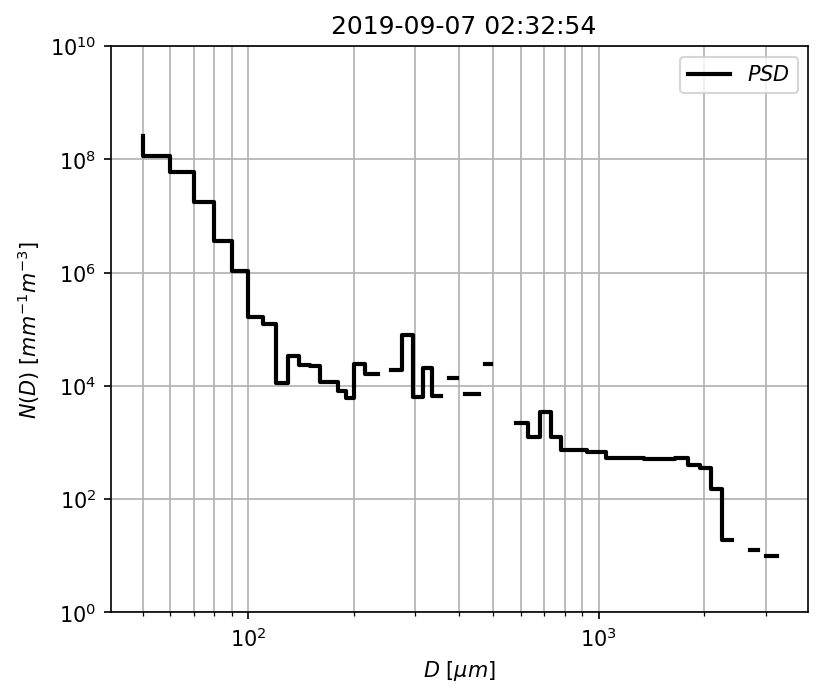

In [38]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
ax.set_xscale('log')
ax.set_yscale('log')
test = ds_lear.sel(time='2019-09-07 2:32:54')
nw = (10 ** (test.log10_nw)).values
mu = test.mu.values
new_mu = test.new_mu.values
mu_bf = test.mu_bf.values
dm = test.dm.values
d = test.diameter / 1000
gm = norm_gamma(d=d,dm=dm, mu=mu, nw=nw)
gm2 = norm_gamma(d=d,dm=dm, mu=new_mu, nw=nw)
# gm3 = norm_gamma(d=d,dm=dm, mu=-0.2, nw=nw)
# gm4 = norm_gamma(d=d,dm=dm, mu=mu_bf, nw=nw)

#M012
eta = (mn(test, n=1) ** 2 / (mn(test, 0) * mn(test, 2))).values
mum = 1 / (1 - eta) - 2
gm012 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)

#M234
eta =  (mn(test, n=3) ** 2 / (mn(test, 2) * mn(test, 4))).values
mum = 1 / (1 - eta) - 4
gm234 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)

# M246
eta = (mn(test, n=4) ** 2 / (mn(test, n=2) * mn(test, n=6))).values
mum = ((7-11 * eta) - (eta ** 2 + 14 * eta + 1) ** 0.5) / (2 * (eta -1))
gm246 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)
print(mum)

# M346
eta = (mn(test, n=4) ** 3 / (mn(test, n=3) ** 2 * mn(test, n=6))).values
mum = ((8-11 * eta) - (eta ** 2 + 8 * eta) ** 0.5) / (2 * (eta -1))
gm346 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)
print(mum)

# M456
eta = (mn(test, n=5) ** 2 / (mn(test, n=4) * mn(test, n=6))).values
mum = 1 / (1 - eta) - 6
gm456 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)
print(mum)
y = np.where(test.psd.values > 0, test.psd.values, np.nan) * 1e6
y_2ds = np.where(ds_2ds.psd.sel(time='2019-09-07 2:32:54') > 0, ds_2ds.psd.sel(time='2019-09-07 2:32:54'), np.nan) * 1e6
y_hvps = np.where(ds_hvps.psd.sel(time='2019-09-07 2:32:54') > 0, ds_hvps.psd.sel(time='2019-09-07 2:32:54'), np.nan) * 1e6

ax.step(test.diameter, y, label='$PSD$', c='k', lw=2, zorder=10)
# ax.step(test.diameter, gm, label='$NGSD$', lw=2, c='r')
# ax.step(ds_2ds.diameter, y_2ds, label='$2D-S$', lw=2,)
# ax.step(ds_hvps.diameter, y_hvps, label='$HVPS$', lw=2,)
# ax.step(test.diameter, gm2, label='$\mu_{unc}$')
# # ax.step(test.diameter, gm3, label='by hand')
# ax.step(test.diameter, gm4, label='BF')

# ax.step(test.diameter, gm012, label='M012')
# ax.step(test.diameter, gm234, label='M234')
# ax.step(test.diameter, gm246, label='M246')
# ax.step(test.diameter, gm346, label='M346')
# ax.step(test.diameter, gm456, label='M456')

ax.set_ylabel(r'$N(D) \ [mm^{-1} m^{-3}]$')
ax.set_xlabel(r"$D \ [\mu m]$")
ax.legend()
ax.grid(which='both')
ax.set_ylim(1e0, 1e10)
ax.set_title(f"{pd.to_datetime(test.time.values): %Y-%m-%d %H:%M:%S}")


# Titulo

$$Z  = a^{b}$$

In [16]:
def custom_plotfunc(ds, fig, t0, *args, **kwargs):
    print(t0)
    ax = fig.subplots()
    ds = ds.isel(time=t0)
    nw = (10 ** (ds.log10_nw)).values
    mu = ds.mu.values
    new_mu = ds.new_mu.values
    dm = ds.dm.values
    d = (ds.diameter / 1000).values
    gm = norm_gamma(d=d,dm=dm, mu=mu, nw=nw)
    gm2 = norm_gamma(d=d,dm=dm, mu=new_mu, nw=nw)
    
    #M012
    eta = (mn(ds, n=1) ** 2 / (mn(ds, 0) * mn(ds, 2))).values
    mum = 1 / (1 - eta) - 2
    gm012 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)

    #M234
    eta =  (mn(ds, n=3) ** 2 / (mn(ds, 2) * mn(ds, 4))).values
    mum = 1 / (1 - eta) - 4
    gm234 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)

    # M246
    eta = (mn(ds, n=4) ** 2 / (mn(ds, n=2) * mn(ds, n=6))).values
    mum = ((7-11 * eta) - (eta ** 2 + 14 * eta + 1) ** 0.5) / (2 * (eta -1))
    gm246 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)

    # M346
    eta = (mn(ds, n=4) ** 3 / (mn(ds, n=3) ** 2 * mn(ds, n=6))).values
    mum = ((8-11 * eta) - (eta ** 2 + 8 * eta) ** 0.5) / (2 * (eta -1))
    gm346 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)

    # M456
    eta = (mn(ds, n=5) ** 2 / (mn(ds, n=4) * mn(ds, n=6))).values
    mum = 1 / (1 - eta) - 6
    gm456 = norm_gamma(d=d,dm=dm, mu=mum, nw=nw)
    gm4 = norm_gamma(d=d,dm=dm, mu=mu_bf, nw=nw)
    y = np.where(ds.psd.values > 0, ds.psd.values, np.nan) * 1e6
    ax.step(ds.diameter, y, label='$Obs.$', lw=1.5)
    ax.step(ds.diameter, gm, label='$Will$', lw=.85)
    ax.step(ds.diameter, gm2, label='$Will\ Uncorr.$', lw=.85)
    ax.step(ds.diameter, gm012, label='$M012$', lw=.85)
    ax.step(test.diameter, gm4, label='$BF$')
    
    # ax.step(ds.diameter, gm234, label='M234', lw=.85)
    # ax.step(ds.diameter, gm246, label='M246', lw=.85)
    # ax.step(ds.diameter, gm346, label='M346', lw=.85)
    # ax.step(ds.diameter, gm456, label='M456', lw=.85)

    

    ax.set_ylabel(r'$PSD \ [mm^{-1} m^{-3}]$')
    ax.set_xlabel(r"$D \ [\mu m]$")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f"{pd.to_datetime(ds.time.values): %Y-%m-%d %H:%M:%S}")
    ax.grid(which='both')
    ax.set_ylim(1e0, 1e10)
    ax.legend()

In [19]:
# test = ds_lear.sel(time=slice('2019-09-07 2:32:00', '2019-09-07 2:32:20'))
test = ds_lear.sel(time='2019-09-07 02:32')

In [20]:
mov_custom = Movie(da=test.chunk({'time':1, 'diameter':-1}), plotfunc=custom_plotfunc, framedim='time', input_check=False, pixelwidth=1220, pixelheight=920, dpi=150)

NameError: name 'Movie' is not defined

In [21]:
%%time
mov_custom.save(
    '../results/psds.mov',
    parallel=True,
    overwrite_existing=True,
)

NameError: name 'mov_custom' is not defined

In [22]:
from IPython.display import Video
Video("../results/psds.mov")

Text(0.5, 1.0, 'Mu BF')

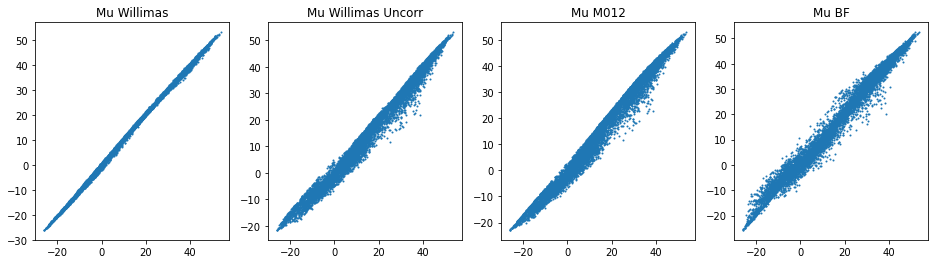

In [64]:
fig, (ax, ax1, ax2, ax3)= plt.subplots(1,4, figsize=(16, 4))
ax.scatter(df['dbz_t_ku'], df['z_ku_mu1'], s=1)
ax.set_title('Mu Willimas')
ax1.scatter(df['dbz_t_ku'], df['z_ku_mu2'], s=1)
ax1.set_title('Mu Willimas Uncorr')
ax2.scatter(df['dbz_t_ku'], df['z_ku_mu3'], s=1)
ax2.set_title('Mu M012')
ax3.scatter(df['dbz_t_ku'], df['z_ku_mu_bf'], s=1)
ax3.set_title('Mu BF')